<a id="top"></a>
#### QCT. Practices with Adiabatic Quantum Computing

# Binary Knapsack Problems

#### Lecturers:
- Rafael Martín-Cuevas Redondo, rafamartinc@pm.me

***

In this notebook, we will explore how to implement a sample Binary Knapsack Problem, and find its solution using the solvers provided by D-Wave Systems.

### Table of Contents

1. [Shaping the QUBO Model](#qubo_model)
2. [Finding the solution with D-Wave's solvers](#solution_dwave)

***

Please run the following block to import the libraries that will be required during the execution of this notebook. If your system lacks any of the libraries mentioned, use ```pip install -r requirements.txt``` in a command line, within this notebook's folder, to ensure that all required libraries are installed.

In [1]:
from sympy import Symbol, Integer, Pow, symbols, expand
from matplotlib import pyplot
import numpy

import neal

[Back to the top](#top)

***
<a id="qubo_model"></a>

## 1. Shaping the QUBO Model

We will start by modeling the Hamiltonian described during the lecture, with a total of seven assets in which we can invest -each one represented by a binary variable that will indicate whether we should invest in that asset or not- and four slack variables that will help us account for solutions that may not need to reach the maximum budget.

During this notebook, we will use the library SymPy for symbolic computation. It is not a Quantum Computing-specific library, and is less ideal than other libraries that are used through other notebooks, but can be used for these purposes as follows.

In [2]:
num_investments = 7
num_slack_variables = 4
alpha = 15
max_weight = 10000000

x = symbols('x_0:%d' % num_investments)      # Define x_0 through x_6.
s = symbols('s_0:%d' % num_slack_variables)  # Define s_0 through s_3.
all_binary_variables = x + s                 # Used to check binary variables.

profits = [120000, 150000, 80000, 360000, 200000, 210000, 300000]
weights = [1000000, 3000000, 2000000, 6000000, 5000000, 3000000, 2000000]
profits_scale_factor = 10000
weights_scale_factor = 1000000

H = - sum([
    profits[i] * x[i] / profits_scale_factor for i in range(num_investments)
]) + alpha * (
    int(max_weight / weights_scale_factor)
    - sum([weights[i] * x[i] / weights_scale_factor for i in range(num_investments)])
    - s[0] - 2*s[1] - 4*s[2] - 3*s[3]
)**2

print(H)

-12*x_0 - 15*x_1 - 8*x_2 - 36*x_3 - 20*x_4 - 21*x_5 - 30*x_6 + 15*(-s_0 - 2*s_1 - 4*s_2 - 3*s_3 - x_0 - 3*x_1 - 2*x_2 - 6*x_3 - 5*x_4 - 3*x_5 - 2*x_6 + 10)**2


We observe that SymPy does not make any modifications in our Hamiltonian by default.

We need to express this Hamiltonian as a standard QUBO model -made up of both clear linear and quadratic terms over binary variables- that can be recognized by the solvers, i.e. as a Python dictionary where each key is an immutable tuple that contains the name of the two binary variables associated to that term, and where the associated value is the coefficient itself.

We need to expand the Hamiltonian first, so that the coefficient associated to each term can be easily identified, to then convert it to a dictionary. SymPy can be used to perform this calculation automatically, offering an improvement over previous exercises in which we did the calculations by hand.

In [3]:
H = expand(H)
print(H)

15*s_0**2 + 60*s_0*s_1 + 120*s_0*s_2 + 90*s_0*s_3 + 30*s_0*x_0 + 90*s_0*x_1 + 60*s_0*x_2 + 180*s_0*x_3 + 150*s_0*x_4 + 90*s_0*x_5 + 60*s_0*x_6 - 300*s_0 + 60*s_1**2 + 240*s_1*s_2 + 180*s_1*s_3 + 60*s_1*x_0 + 180*s_1*x_1 + 120*s_1*x_2 + 360*s_1*x_3 + 300*s_1*x_4 + 180*s_1*x_5 + 120*s_1*x_6 - 600*s_1 + 240*s_2**2 + 360*s_2*s_3 + 120*s_2*x_0 + 360*s_2*x_1 + 240*s_2*x_2 + 720*s_2*x_3 + 600*s_2*x_4 + 360*s_2*x_5 + 240*s_2*x_6 - 1200*s_2 + 135*s_3**2 + 90*s_3*x_0 + 270*s_3*x_1 + 180*s_3*x_2 + 540*s_3*x_3 + 450*s_3*x_4 + 270*s_3*x_5 + 180*s_3*x_6 - 900*s_3 + 15*x_0**2 + 90*x_0*x_1 + 60*x_0*x_2 + 180*x_0*x_3 + 150*x_0*x_4 + 90*x_0*x_5 + 60*x_0*x_6 - 312*x_0 + 135*x_1**2 + 180*x_1*x_2 + 540*x_1*x_3 + 450*x_1*x_4 + 270*x_1*x_5 + 180*x_1*x_6 - 915*x_1 + 60*x_2**2 + 360*x_2*x_3 + 300*x_2*x_4 + 180*x_2*x_5 + 120*x_2*x_6 - 608*x_2 + 540*x_3**2 + 900*x_3*x_4 + 540*x_3*x_5 + 360*x_3*x_6 - 1836*x_3 + 375*x_4**2 + 450*x_4*x_5 + 300*x_4*x_6 - 1520*x_4 + 135*x_5**2 + 180*x_5*x_6 - 921*x_5 + 60*x_6**2 - 63

The following block of code iterates through the terms contained in this mathematical expression, and converts them to the data structure we are looking for.

The full polynomial is made up of several monomials put together through additions or substractions. Each one of the individual monomials is made up of a product containing one or several constant coefficients or binary variables. Those monomials with just one variable are linear terms -even those that contain the same binary variable squared-, and the ones with two variables are the quadratic terms.

In [4]:
qubo = {}

for monomial in H.args:
    
    coefficient = None
    
    # The final dictionary will use tuples as keys, as Python dictionaries
    # require the keys to be immutable, but we will use lists until we have
    # clarified the final contents of each key.
    key = []
    
    for variable in monomial.args:
        
        # Linear terms - Simple binary variables.
        if isinstance(variable, Symbol) and variable in all_binary_variables:
            key.append(str(variable))
            
        # Squared binary variables. In QUBO's, x_i^2 == x_i.
        elif isinstance(variable, Pow) \
                and variable.args[0] in all_binary_variables:
            key.append(str(variable.args[0]))
            
        # Constant coefficients.
        elif isinstance(variable, Integer):
            coefficient = variable
    
    if len(key) == 1:
        key = key + key
    key = tuple(key)
    
    if len(key) == 2:
        if key not in qubo:
            qubo[key] = float(coefficient)
        else:
            qubo[key] += float(coefficient)
            
print(qubo)

{('x_3', 'x_3'): -1296.0, ('x_4', 'x_4'): -1145.0, ('s_2', 's_2'): -960.0, ('x_5', 'x_5'): -786.0, ('x_1', 'x_1'): -780.0, ('s_3', 's_3'): -765.0, ('x_6', 'x_6'): -570.0, ('x_2', 'x_2'): -548.0, ('s_1', 's_1'): -540.0, ('x_0', 'x_0'): -297.0, ('s_0', 's_0'): -285.0, ('s_0', 'x_0'): 30.0, ('s_0', 's_1'): 60.0, ('s_0', 'x_2'): 60.0, ('s_0', 'x_6'): 60.0, ('s_1', 'x_0'): 60.0, ('x_0', 'x_2'): 60.0, ('x_0', 'x_6'): 60.0, ('s_0', 's_3'): 90.0, ('s_0', 'x_1'): 90.0, ('s_0', 'x_5'): 90.0, ('s_3', 'x_0'): 90.0, ('x_0', 'x_1'): 90.0, ('x_0', 'x_5'): 90.0, ('s_0', 's_2'): 120.0, ('s_1', 'x_2'): 120.0, ('s_1', 'x_6'): 120.0, ('s_2', 'x_0'): 120.0, ('x_2', 'x_6'): 120.0, ('s_0', 'x_4'): 150.0, ('x_0', 'x_4'): 150.0, ('s_0', 'x_3'): 180.0, ('s_1', 's_3'): 180.0, ('s_1', 'x_1'): 180.0, ('s_1', 'x_5'): 180.0, ('s_3', 'x_2'): 180.0, ('s_3', 'x_6'): 180.0, ('x_0', 'x_3'): 180.0, ('x_1', 'x_2'): 180.0, ('x_1', 'x_6'): 180.0, ('x_2', 'x_5'): 180.0, ('x_5', 'x_6'): 180.0, ('s_1', 's_2'): 240.0, ('s_2', 'x

We have now expressed our QUBO model as a data structure that can be recognized by our solvers.

[Back to the top](#top)

***
<a id="solution_dwave"></a>

## 2. Finding the solution with D-Wave's solvers

Finally, we can use the solvers provided by D-Wave to find the solution to this problem, as follows. We use the code to aggregate the solutions provided by the quantum annealer, and identify the variables that are set to 1 in our solution, indicating which assets should be picked as part of our portfolio. Remember that the slack variables hold no meaning, beyond the purpose of providing the quantum annealer with a way to pick solutions that do not require the total budget, so in this example we can just ignore them from our final solution.

In this example, and given the small size that this problem has, we can just use the local simulator, but please feel free to expand this example for larger datasets and try a cloud solver or a quantum annealer if you want to do so.

In [5]:
sampler = neal.SimulatedAnnealingSampler()
num_reads = 5000

response = sampler.sample_qubo(qubo, num_reads=num_reads)
response = response.aggregate()

for values, _, num_occurrences in response.data():
    variables = [key for key in values if values[key] != 0]
    print('{:4.0f}/{} occurrences: {}'.format(
        num_occurrences, num_reads, variables
    ))

 471/5000 occurrences: ['s_0', 'x_0', 'x_3', 'x_6']
 708/5000 occurrences: ['s_0', 'x_0', 'x_1', 'x_5', 'x_6']
 248/5000 occurrences: ['x_1', 'x_2', 'x_5', 'x_6']
 176/5000 occurrences: ['x_2', 'x_3', 'x_6']
 181/5000 occurrences: ['x_3', 'x_5', 'x_6']
 321/5000 occurrences: ['x_4', 'x_5', 'x_6']
 303/5000 occurrences: ['s_1', 'x_0', 'x_2', 'x_5', 'x_6']
  61/5000 occurrences: ['x_0', 'x_2', 'x_3', 'x_6']
  80/5000 occurrences: ['x_0', 'x_1', 'x_2', 'x_5', 'x_6']
 331/5000 occurrences: ['x_0', 'x_2', 'x_4', 'x_6']
  96/5000 occurrences: ['x_0', 'x_3', 'x_5']
  91/5000 occurrences: ['x_0', 'x_4', 'x_5', 'x_6']
  67/5000 occurrences: ['x_1', 'x_3', 'x_6']
  11/5000 occurrences: ['s_1', 'x_1', 'x_5', 'x_6']
   4/5000 occurrences: ['s_1', 'x_3', 'x_6']
 157/5000 occurrences: ['s_1', 'x_0', 'x_1', 'x_2', 'x_6']
 175/5000 occurrences: ['x_1', 'x_4', 'x_6']
   4/5000 occurrences: ['x_0', 'x_3', 'x_6']
   4/5000 occurrences: ['s_1', 'x_0', 'x_3', 'x_6']
 243/5000 occurrences: ['s_0', 's_3', 'x

Through the following block of code, we will look for the best solution from the ones provided by the solver, to get: (1) the assurance that the budget constraint is met, (2) a visual representation of the final portfolio and (3) its expected return.

In [6]:
# Get best solution.

best_solution = None
best_solution_occurrences = -1

for values, _, num_occurrences in response.data():
    if num_occurrences > best_solution_occurrences:
        best_solution = values
        best_solution_occurrences = num_occurrences

best_solution_variables = [
    key for key in best_solution
    if best_solution[key] != 0 and key[:2] == 'x_'
]

print('Best solution ({:0.1f}%): {}'.format(
    100 * best_solution_occurrences / num_reads,
    best_solution_variables
))

Best solution (14.2%): ['x_0', 'x_1', 'x_5', 'x_6']


In [7]:
# Check weight constraint.

best_solution_weights = [
    weights[int(key[2:])] for key in best_solution_variables
]
total_weight = sum(best_solution_weights)

print('\nTotal investment: {} < {} - {}'.format(
    total_weight,
    max_weight,
    'OK!' if total_weight < max_weight else 'ERROR'
))
for key in best_solution_variables:
    asset_id = int(key[2:])
    print('   {}: {}'.format(key, weights[asset_id]))

print('\n   Cash: {}'.format(max_weight - total_weight))


Total investment: 9000000 < 10000000 - OK!
   x_0: 1000000
   x_1: 3000000
   x_5: 3000000
   x_6: 2000000

   Cash: 1000000


In [8]:
# Calculate expected return and rentability.

best_solution_profits = [
    profits[int(key[2:])] for key in best_solution_variables
]
total_profit = sum(best_solution_profits)

print('\nTotal expected profit: {} ({:0.1f}%)'.format(total_profit, 100 * total_profit / total_weight))
for key in best_solution_variables:
    asset_id = int(key[2:])
    print('   {}: {} ({:0.1f}%)'.format(
        key,
        profits[asset_id],
        100 * profits[asset_id] / weights[asset_id]
    ))


Total expected profit: 780000 (8.7%)
   x_0: 120000 (12.0%)
   x_1: 150000 (5.0%)
   x_5: 210000 (7.0%)
   x_6: 300000 (15.0%)


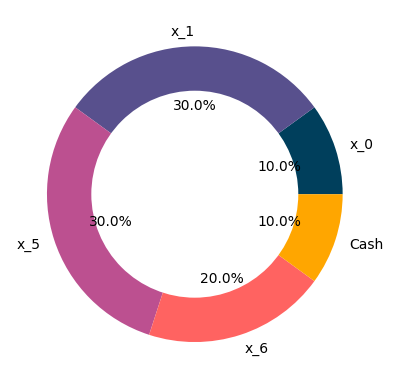

In [9]:
# Visualize pie chart.

y = numpy.array(best_solution_weights + [max_weight - total_weight])
pyplot.pie(
    y, labels=best_solution_variables + ['Cash'],
    colors=['#003f5c','#58508d','#bc5090','#ff6361','#ffa600'], autopct='%1.1f%%'
)
pyplot.gcf().gca().add_artist(pyplot.Circle((0,0), 0.70, fc='white'))
pyplot.show()

[Back to the top](#top)